In [ ]:
# import 
import os
import pandas as pd
import numpy as np
import random
import time
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive, files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Environment
SEED = 7773
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED) # for reproducibility
tf.random.set_seed(SEED) # for reproducibility

In [ ]:
import sys

py_file_location = "/content/drive/MyDrive/CS Graduation Project/Source Code/final demo/"
sys.path.append(os.path.abspath(py_file_location))
import m_utils as util

In [ ]:
# Statistic Class
import scipy.stats

class Statistics:
    def __init__(self,series):
        self.series = np.array(series)
        self.n = len(series)
    def mean(self):
        return np.mean(self.series)
    def std(self):
        return np.std(self.series)
    def stderr(self):
        return scipy.stats.sem(self.series)
    def percentiles(self,p=[.25,.5,.75]):
        return pd.Series(self.series).describe(percentiles=p)
    def pos_perc(self):
        return 100*sum(self.series>0)/self.n
    def skewness(self):
        return scipy.stats.skew(self.series)
    def kurtosis(self):
        return scipy.stats.kurtosis(self.series)
    def VaR(self,confidence):
        indx = int(confidence*self.n/100)
        return sorted(self.series)[indx-1]
    def CVaR(self,confidence):
        indx = int(confidence*self.n/100)
        return sum(sorted(self.series)[:indx])/indx
    def MDD(self):
        money = np.cumprod(1+self.series/100)
        maximums = np.maximum.accumulate(money)
        drawdowns = 1 - money/maximums
        return np.max(drawdowns)
    # def sharpe(self,risk_free_rate = 0.005): # 0.0003 -> 0.005
    #     mu = self.mean()
    #     sig = self.std()
    #     sharpe_d = (mu-risk_free_rate)/sig
    #     return (252**0.5)*sharpe_d 
    def yearly_rets(self):
        total_ret = self.series
        return total_ret.sum(axis=0)    
    def shortreport(self):
        print('Mean \t\t',self.mean())
        print('Standard dev \t',self.std())
        print('Yearly Average Return \t',self.yearly_rets())
        # print('Sharpe ratio \t',self.sharpe())      
    def report(self):
        print('Mean \t\t',self.mean())
        print('Standard dev \t',self.std())
        print('Yearly Average Return \t',self.yearly_rets())
        # print('Sharpe ratio \t',self.sharpe())
        print('Standard Error \t',self.stderr())
        print('Share>0 \t',self.pos_perc())
        print('Skewness \t',self.skewness())
        print('Kurtosis \t',self.kurtosis())
        print('VaR_1 \t\t',self.VaR(1))
        print('VaR_2 \t\t',self.VaR(2))
        print('VaR_5 \t\t',self.VaR(5))
        print('CVaR_1 \t\t',self.CVaR(1))
        print('CVaR_2 \t\t',self.CVaR(2))
        print('CVaR_5 \t\t',self.CVaR(5))
        print('MDD \t\t',self.MDD())
        print(self.percentiles())


**Def Functions**

In [ ]:
#-----------------------------------------------------------------------------
# ---- Load Trained model and Make Hypothesis ----#
def trained(filename,train_data,test_data):
    model = load_model(filename)
    dates = list(set(test_data[:,0]))
    predictions = {}

    for day in dates:
        test_d = test_data[test_data[:,0]==day]
        test_d = np.reshape(test_d[:,2:-2], (len(test_d),240,5)).astype(np.float32)
        predictions[day] = model.predict(test_d)[:,1]
    return model,predictions

In [ ]:
model_folder   = '/content/drive/MyDrive/CS Graduation Project/Source Code/final demo/model/'
result_folder  = '/content/drive/MyDrive/CS Graduation Project/Source Code/final demo/result/'
data_folder    = '/content/drive/MyDrive/CS Graduation Project/Source Code/final demo/data/'

In [ ]:
rets_file = result_folder+'avg_returns.txt'
if os.path.exists(rets_file):
    os.remove(rets_file)
    print('avg_returns.txt is rewriting...') 
for test_year in range(2015,2021):

    model_path = model_folder+ 'model-LSTM-' + str(test_year) + '-240.h5'
    print(10*'-'+'Predicting '+str(test_year)+' data'+'-'*10)

    # Load processed data 
    train_data,test_data = [],[]    
    train_data = np.load(data_folder+'train_data-'+str(test_year)+'.npy', allow_pickle=True)
    test_data = np.load(data_folder+'test_data-'+str(test_year)+'.npy', allow_pickle=True)
    print('train data: '+str(train_data.shape))
    print('test data: '+str(test_data.shape))

    # Prediction
    
    start = time.time()
    model, predictions = trained(model_path, train_data, test_data)
    print('runtime: '+str(time.time()-start))
    # Trading simulate
    ind_daily, count_index, returns = util.simulate(test_data,predictions)
    dayly_indexes = util.daily_indexes(test_data, predictions)

    with open(result_folder+'predictions-'+str(test_year)+'.pickle', 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

    ind_daily.to_csv(result_folder+'ind_daily_rets-'+str(test_year)+'.csv')
    returns.to_csv(result_folder+'avg_daily_rets-'+str(test_year)+'.csv')
    with open(result_folder+"avg_returns.txt", "a") as myfile:
        res = '-'*30 + '\n'
        res += str(test_year) + '\n'
        res += 'Index Freq:'+'\n'
        for row in count_index:
          res += '  +-+' +str(row) +': '+str(count_index[row])+'\n'
        res += '-'*30 + '\n'
        myfile.write(res)

avg_returns.txt is rewriting...
----------Predicting 2015 data----------
train data: (12593, 1204)
test data: (6902, 1204)
runtime: 26.403311729431152
----------Predicting 2016 data----------
train data: (12170, 1204)
test data: (7110, 1204)
runtime: 24.35814332962036
----------Predicting 2017 data----------
train data: (11451, 1204)
test data: (6724, 1204)
runtime: 23.696962356567383
----------Predicting 2018 data----------
train data: (10283, 1204)
test data: (6426, 1204)
runtime: 23.3637056350708
----------Predicting 2019 data----------
train data: (10709, 1204)
test data: (5640, 1204)
runtime: 22.7778799533844
----------Predicting 2020 data----------
train data: (11188, 1204)
test data: (5324, 1204)
runtime: 22.878081560134888


=======================2015=======================
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+33.21%): 44401841.54669356
Asset 2(+16.35%): 38781822.82919148
Asset 3(+46.0%): 48665156.07363116
---------------------------------------------
Total Asset (+31.849%): 131848820.4495162


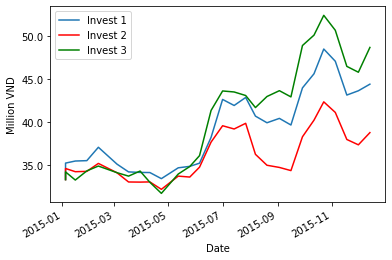

=======================2016=======================
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+17.24%): 39079507.04659071
Asset 2(+6.89%): 35630942.34339294
Asset 3(+22.12%): 40707300.79990422
---------------------------------------------
Total Asset (+15.418%): 115417750.18988788


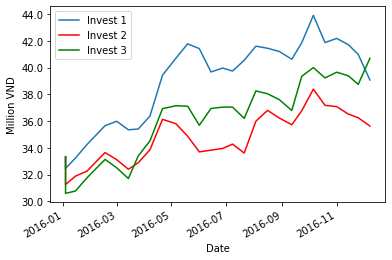

=======================2017=======================
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+21.41%): 40468431.4568612
Asset 2(+27.46%): 42486552.250672765
Asset 3(+16.74%): 38914786.558681525
---------------------------------------------
Total Asset (+21.87%): 121869770.26621547


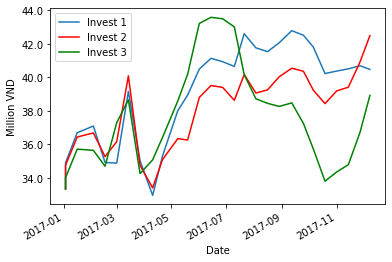

=======================2018=======================
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(-23.56%): 25480879.242804784
Asset 2(-22.86%): 25714838.611945584
Asset 3(+4.78%): 34926756.915873446
---------------------------------------------
Total Asset (-13.878%): 86122474.7706238


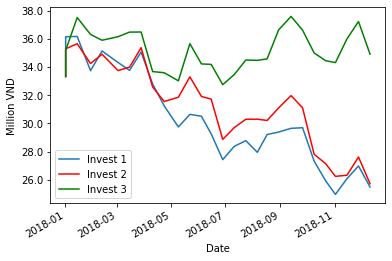

=======================2019=======================
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+10.56%): 36853856.338245325
Asset 2(+22.31%): 40768880.395443395
Asset 3(+4.11%): 34704794.1156844
---------------------------------------------
Total Asset (+12.328%): 112327530.8493731


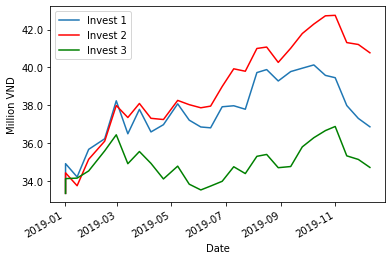

=======================2020=======================
Investment: 100000000
Original Splitted Asset: 33333334 - 33333334 - 33333334
Asset 1(+25.12%): 41705389.476381116
Asset 2(+14.32%): 38106348.943296
Asset 3(+14.97%): 38322253.84525427
---------------------------------------------
Total Asset (+18.134%): 118133992.26493138


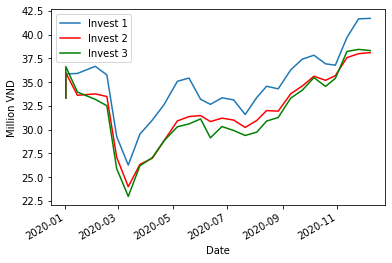

In [ ]:
# Print and plot trading results
util.trading_plot_main(result_folder+'avg_daily_rets-')